In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [80]:
algorithms = ['PL', 'STC', 'CC', 'HLNC', 'OBNC', 'BE']

alg_names = {
    'PL': 'Polishing Labels',
    'STC': 'Self-Training Correction',
    'CC': 'Clustering-Based Correction',
    'HLNC': 'Hybrid Label Noise Correction',
    'OBNC': 'Ordering-Based Noise Correction',
    'BE': 'Bayesian Entropy'
}

attr = {
    'ads': 'local',
    'bank': 'housing',
    'biodeg': 'V25',
    'churn': 'voice_mail_plan',
    'credit': 'A1',
    'monks1': 'attr3',
    'phishing': 'having_IP_Address',
    'sick': 'referral_source_other',
    'vote': 'immigration'
}

attr_fairness = {
    'adult': ['sex_Male', 'race_White'],
    'german': ['sex_Male'],
    'compas': ['sex', 'race_Caucasian'],
    'ricci': ['Race_W'],
    'diabetes': ['race_Caucasian'],
    'titanic': ['sex']
}

noise_types = ['random', 'flip', 'bias', 'balanced_bias']
type_names = {'random': 'Random', 
            'flip': 'Label Flipping', 
            'bias': 'Asymmetrical Bias',
            'balanced_bias': 'Symmetrical Bias'}

colors = {'PL':'tab:blue', 
          'STC':'tab:orange', 
          'CC':'tab:green', 
          'HLNC':'tab:red', 
          'OBNC':'tab:purple', 
          'BE':'tab:brown'}

markers = {
    0: 'o',
    0.1: 's',
    0.2: 'v',
    0.3: 'D',
    0.4: 'P',
    0.5: 'p'
}

pred_metrics = ['accuracy_0.5', 'roc_auc']

fair_metrics = [
        'equal_opportunity_difference_0.5', 
        'predictive_equality_difference_0.5',
        'demographic_parity_difference_0.5',
        'equalized_odds_difference_0.5']

metric_names = {
    'accuracy_0.5': 'Accuracy',
    'roc_auc': 'AUC',
    'equal_opportunity_difference_0.5': 'Equal Opportunity dif.',
    'predictive_equality_difference_0.5': 'Predictive Equality dif.',
    'demographic_parity_difference_0.5': 'Demographic Parity dif.',
    'equalized_odds_difference_0.5': 'Equalized Odds dif.'
}

metrics = pred_metrics + fair_metrics

nr = [i/10 for i in range(1, 6)]

In [81]:
runs = {}
for noise_type in noise_types:
    runs[noise_type] = {}
    for dataset in attr.keys():
        exp = f'{dataset}_{attr[dataset]}'
        for alg in algorithms:
            runs[noise_type][f'{exp}_{alg}'] = pd.read_csv(f'../noiseinjection_results/{noise_type}/{exp}_{alg}.csv').fillna(0)
runs['fairness'] = {}
for dataset in attr_fairness.keys():
    for sensitive_attr in attr_fairness[dataset]:
        exp = f'{dataset}_{sensitive_attr}'
        for alg in algorithms:
            runs['fairness'][f'{exp}_{alg}'] = pd.read_csv(f'../fairness_benchmark_results/{exp}_{alg}.csv').fillna(0)

In [82]:
if not os.path.exists('thesis_report/fairness_benchmarks'):
    os.makedirs('thesis_report/fairness_benchmarks')

if not os.path.exists('thesis_report/noise_injection'):
    os.makedirs('thesis_report/noise_injection')

# Functions

In [83]:
def get_dataset_stats(datasets):
    dataset_stats = pd.DataFrame(columns=['instances', 'features', 'positive (%)', 'protected (%)', 'positive in protected group (%)', 'positive in unprotected group (%)'])

    for dataset in datasets:
        data = pd.read_csv(f'../data/{dataset}.csv')
        dataset_stats.loc[dataset] = [
            data.shape[0],
            data.shape[1] - 1,
            "{:.0f} %".format((data[data['y'] == 1].shape[0]/data.shape[0])*100),
            "{:.0f} %".format((data[data[attr[dataset]] == 1].shape[0]/data.shape[0])*100),
            "{:.0f} %".format((data[(data[attr[dataset]] == 1) & (data['y'] == 1)].shape[0]/data[data[attr[dataset]] == 1].shape[0])*100),
            "{:.0f} %".format((data[(data[attr[dataset]] == 0) & (data['y'] == 1)].shape[0]/data[data[attr[dataset]] == 0].shape[0])*100),
        ]

    return dataset_stats

In [84]:
def similiarity(algorithms):
    fig = plt.figure(figsize=(12, 4))
    axs = fig.subplots(1, 2, sharey=True, sharex=True)

    for i in range(2):
        ax = axs[i]
        
        for alg in algorithms:
            values = []
            for noise_rate in nr:
                avg_value = []
                for dataset in attr.keys():
                    exp = f'{dataset}_{attr[dataset]}'
                    run = runs[noise_types[i+2]][f'{exp}_{alg}']
                    avg_value.append(run.loc[run['params.noise_rate'] == noise_rate][f'metrics.correction_acc'].mean())
                values.append(np.mean(avg_value))
            
            ax.plot(nr, values, label=alg)
        
        ax.set_xlabel('Noise rate', fontsize=14)         
        if i == 0:
            ax.set_ylabel('Reconstruction Score, $r$', fontsize=14)
        ax.set_title(f'Noise type: {type_names[noise_types[i+2]]}', fontsize=14)

    ax.legend(fontsize=12)
    plt.subplots_adjust(wspace=0.07, hspace=0.15)
    plt.savefig('thesis_report/noise_injection/similarity.png', bbox_inches='tight')
    plt.show()

In [85]:
def trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax, noisy=False):
    predictive_performance = []
    fairness = []

    if test_set == 'original':
        pred_original = []
        fair_original = []

    for dataset in attr.keys():
        exp = f'{dataset}_{attr[dataset]}'
        run = runs[noise_type][f'{exp}_{alg}']
        run = run.loc[(run['tags.test_set'] == test_set) & (run['params.noise_rate'].isin(nr))]

        if noisy:
            train_set = 'noisy'
        else:
            train_set = 'corrected'

        predictive_performance.append(run.loc[(run['tags.train_set'] == train_set)].sort_values(by='params.noise_rate', ascending=True)['metrics.roc_auc'].values)
        fairness.append(run.loc[(run['tags.train_set'] == train_set)].sort_values(by='params.noise_rate', ascending=True)[f'metrics.{fair_metric}'].values)
        
        if test_set == 'original':
            pred_original.append(run.loc[(run['tags.train_set'] == 'original') & (run['params.noise_rate'] == 0.1)]['metrics.roc_auc'].values[0])
            fair_original.append(run.loc[(run['tags.train_set'] == 'original') & (run['params.noise_rate'] == 0.1)][f'metrics.{fair_metric}'].values[0])
        
    if test_set == 'original':
        predictive_performance = [np.mean(pred_original)] + list(np.mean(np.array(predictive_performance), axis=0))
        fairness = [np.mean(fair_original)] + list(np.mean(np.array(fairness), axis=0))
    else:
        predictive_performance = list(np.mean(np.array(predictive_performance), axis=0))
        fairness = list(np.mean(np.array(fairness), axis=0))
    
    if test_set == 'original':
        nr = [0.0] + nr

    if noisy:
        ax.plot(fairness, predictive_performance, color='red', linestyle='--')
        for i in range(len(nr)):
            ax.scatter(fairness[i], predictive_performance[i], color='red', marker=markers[nr[i]], label=f'Noise rate = {nr[i]}')
    else:
        ax.plot(fairness, predictive_performance, color=colors[alg])
        for i in range(len(nr)):
            ax.scatter(fairness[i], predictive_performance[i], color=colors[alg], marker=markers[nr[i]])

In [86]:
def trade_off_separate_algs(noise_type, test_set, fair_metric, nr):
    fig = plt.figure(figsize=(12, 12))
    axs = fig.subplots(3, 2, sharey=True, sharex=True)

    for i in range(6):
        alg = algorithms[i]
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax)
        trade_off_curve('PL', noise_type, test_set, fair_metric, nr, ax, noisy=True)
        
        if row == 2:
            ax.set_xlabel(metric_names[fair_metric], fontsize=14) 
        if col == 0:
            ax.set_ylabel('AUC', fontsize=14)
        ax.set_title(alg_names[alg], fontsize=14)

    axs[0, 0].legend(fontsize=12)
    plt.suptitle(f'Noise type: {type_names[noise_type]}', fontsize=16, y=0.93)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.savefig(f'thesis_report/noise_injection/{test_set}_test_{fair_metric}_{noise_type}.png', bbox_inches='tight')
    plt.show()

In [87]:
def show_corrected_test_performance(noise_type, metric):
    fig = plt.figure(figsize=(12, 8))
    axs = fig.subplots(3, 2, sharey=True, sharex=True)

    for i in range(6):
        row = i // 2
        col = i % 2
        alg = algorithms[i]

        results = {noise_rate: [] for noise_rate in nr}
        results_original = {noise_rate: [] for noise_rate in nr}

        for dataset in attr.keys():
            exp = f'{dataset}_{attr[dataset]}'
            run = runs[noise_type][f'{exp}_{alg}']
            run = run.loc[run['tags.test_set'] == 'corrected']
            for noise_rate in nr:
                results[noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0])
            
            run = runs[noise_type][f'{exp}_{alg}']
            run = run.loc[run['tags.test_set'] == 'original']
            for noise_rate in nr:
                results_original[noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0])
            
        axs[row, col].plot(nr, [np.mean(results_original[noise_rate]) for noise_rate in nr], label='original test set', color='black', linestyle='--', linewidth=2)
        axs[row, col].errorbar(nr, [np.mean(results[noise_rate]) for noise_rate in nr], yerr=[np.std(results[noise_rate]) for noise_rate in nr] , label=f'{alg} corrected test set', color=colors[alg])

        if row == 2:
            axs[row, col].set_xlabel('Noise rate', fontsize=14)
        if col == 0:
            axs[row, col].set_ylabel(metric_names[metric], fontsize=12)

        axs[row, col].legend(fontsize=12)
        axs[row, col].set_title(f'Train set: {alg} corrected', fontsize=14)

    plt.subplots_adjust(wspace=0.07, hspace=0.2)
    plt.suptitle(f'Noise type: {type_names[noise_type]}', fontsize=16, y=0.95)
    plt.savefig(f'thesis_report/noise_injection/corrected_test_{metric}_{noise_type}.png', bbox_inches='tight')
    plt.show()

# Noise injection experiments

## Dataset characterization

In [88]:
get_dataset_stats(attr.keys())

,instances,features,positive (%),protected (%),positive in protected group (%),positive in unprotected group (%)
ads,1377,1558,33 %,76 %,34 %,33 %
bank,15111,30,33 %,51 %,24 %,43 %
biodeg,1055,41,34 %,15 %,5 %,39 %
churn,2121,22,33 %,23 %,21 %,37 %
credit,653,43,45 %,31 %,47 %,45 %
monks1,556,6,50 %,49 %,49 %,51 %
phishing,11055,30,56 %,66 %,59 %,49 %
sick,636,26,33 %,39 %,12 %,47 %
vote,312,14,58 %,52 %,54 %,63 %


## Similarity to original labels

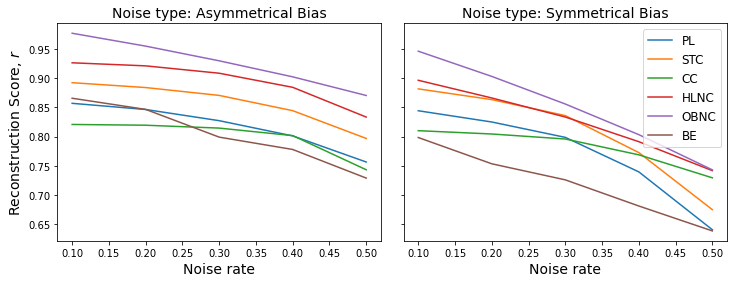

In [89]:
similiarity(algorithms)

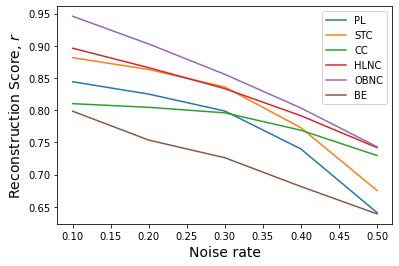

In [90]:
for alg in algorithms:
    values = []
    for noise_rate in nr:
        avg_value = []
        for dataset in attr.keys():
            exp = f'{dataset}_{attr[dataset]}'
            run = runs['balanced_bias'][f'{exp}_{alg}']
            avg_value.append(run.loc[run['params.noise_rate'] == noise_rate][f'metrics.correction_acc'].mean())
        values.append(np.mean(avg_value))
    
    plt.plot(nr, values, label=alg)

plt.xlabel('Noise rate', fontsize=14)         
plt.ylabel('Reconstruction Score, $r$', fontsize=14)

plt.legend()
plt.show()

## Noisy test set

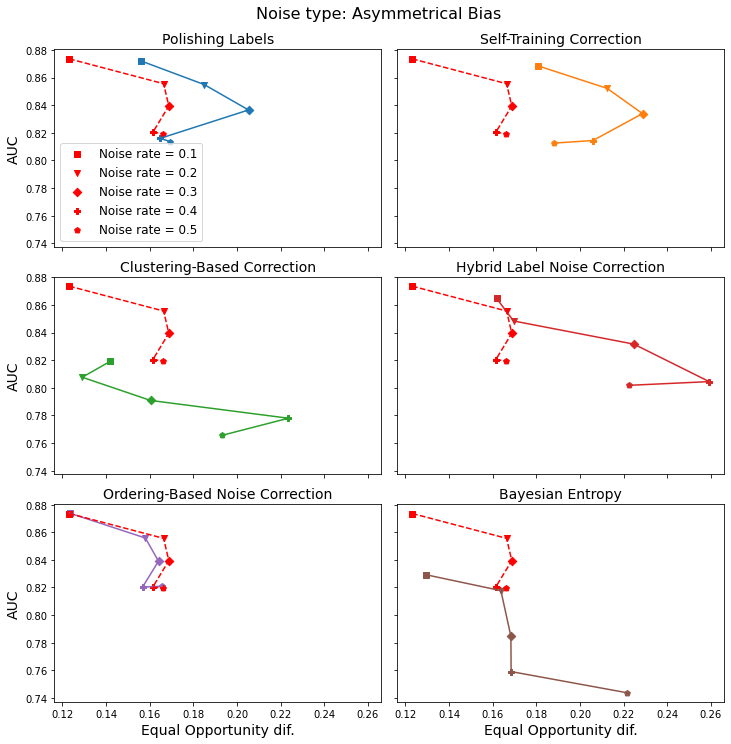

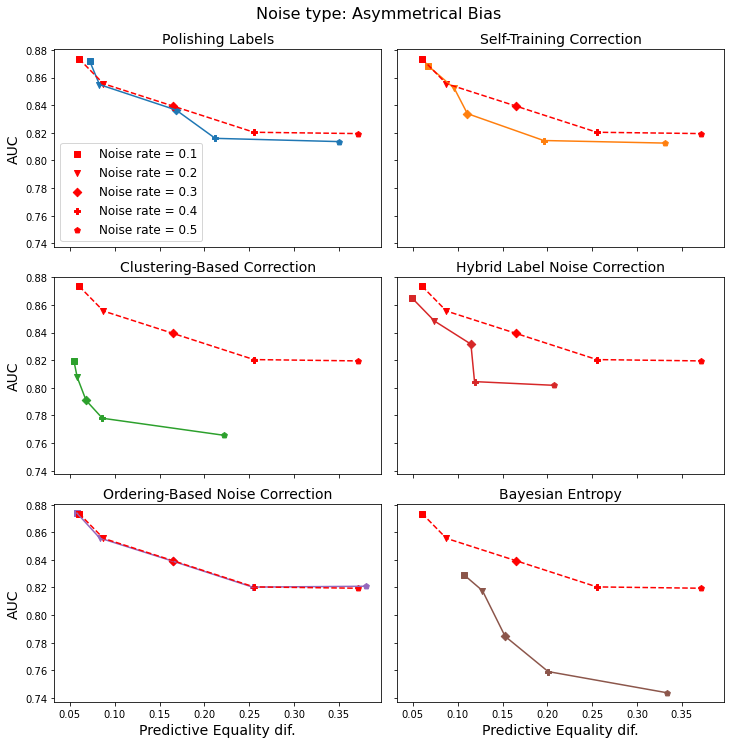

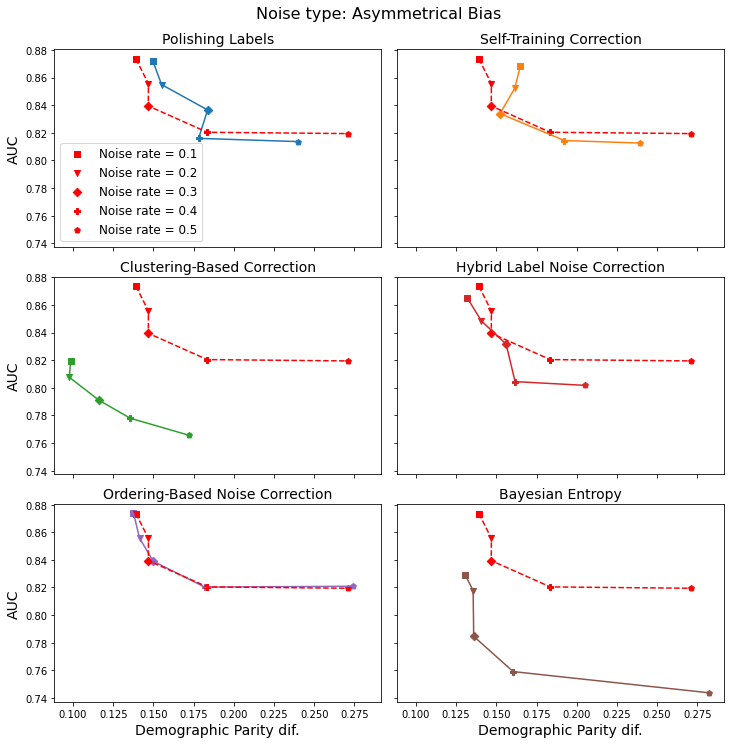

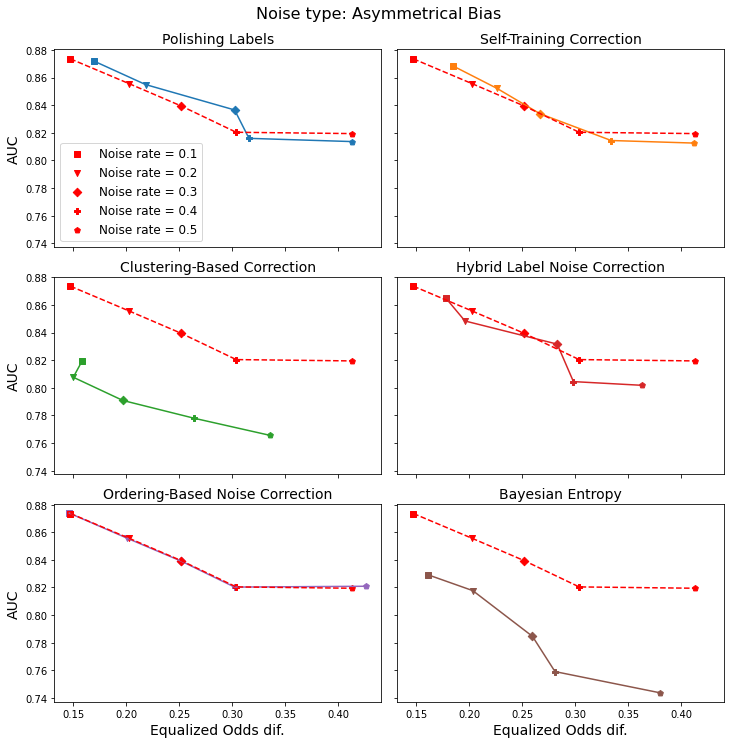

In [91]:
for fair_metric in fair_metrics:
    trade_off_separate_algs('bias', 'noisy', fair_metric ,nr)

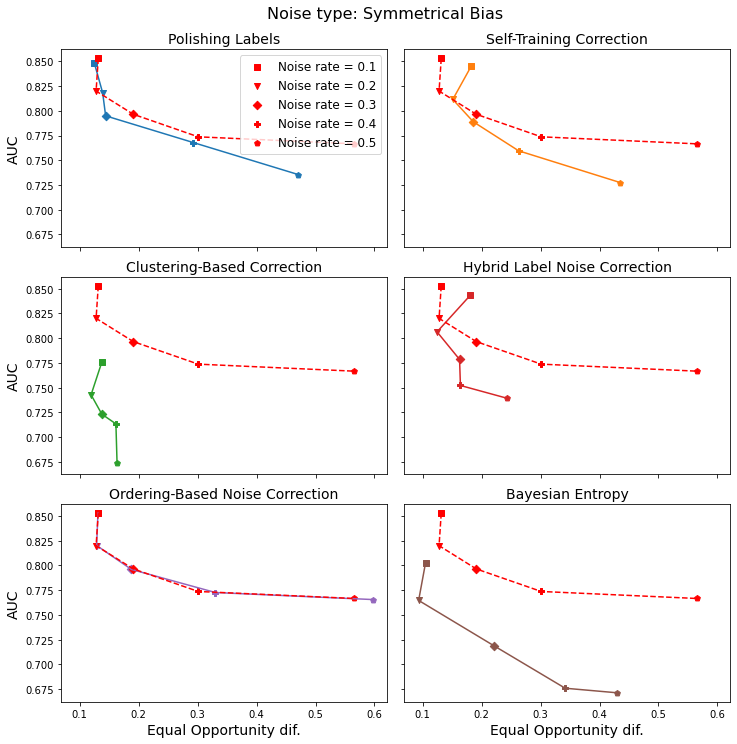

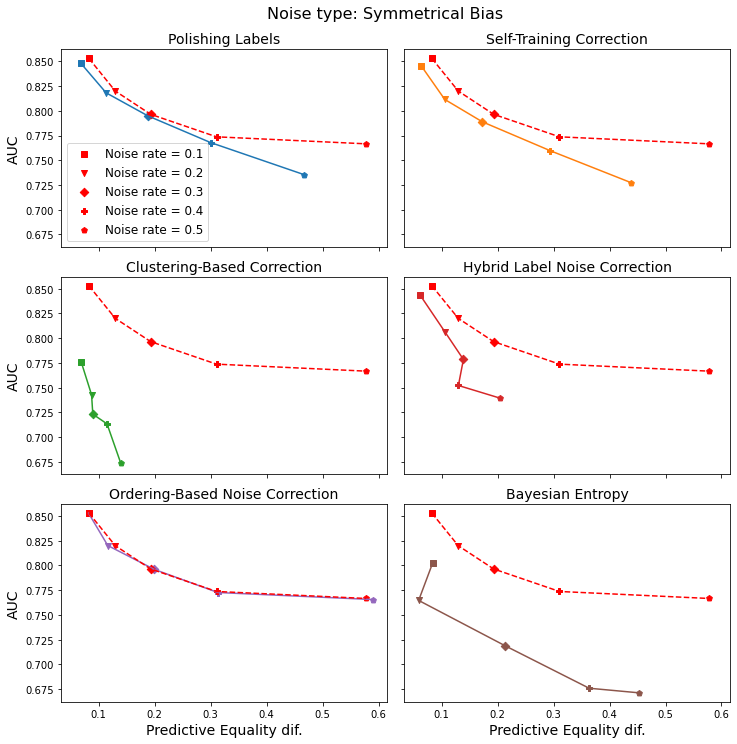

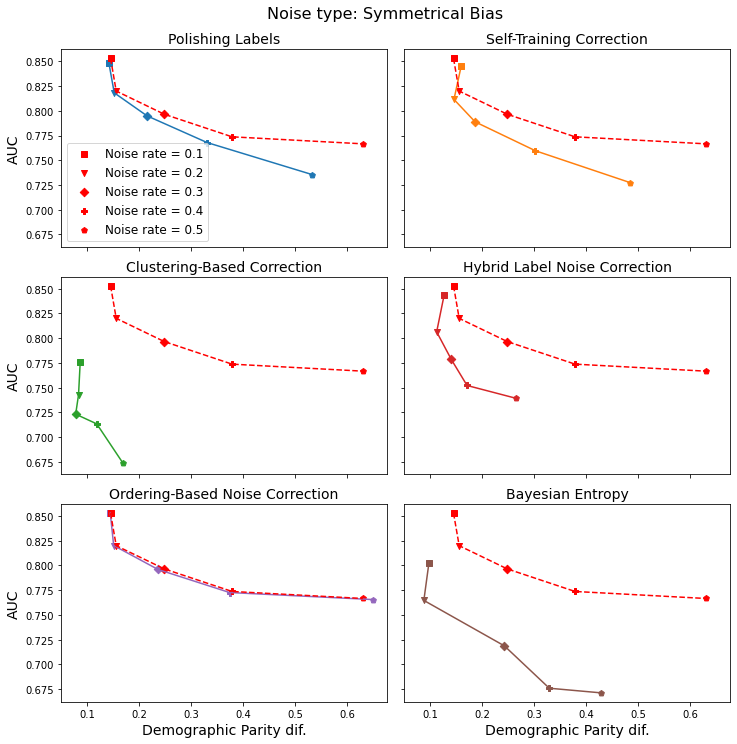

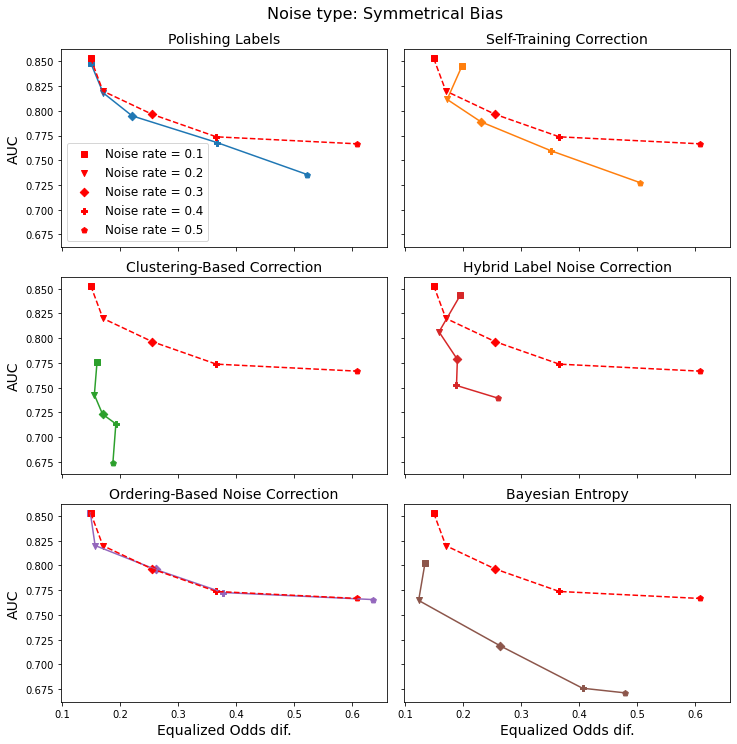

In [92]:
for fair_metric in fair_metrics:
    trade_off_separate_algs('balanced_bias', 'noisy', fair_metric, nr)

## Original test set

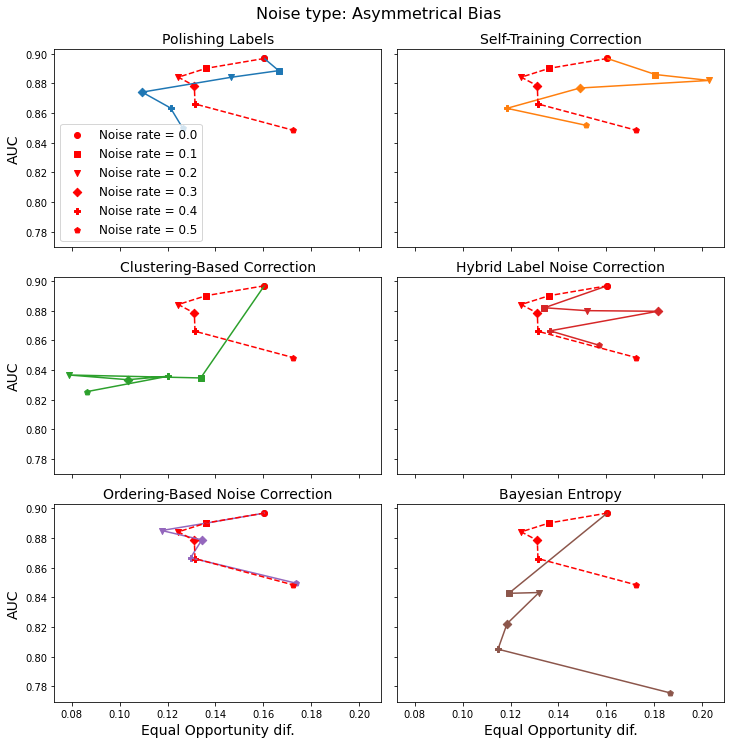

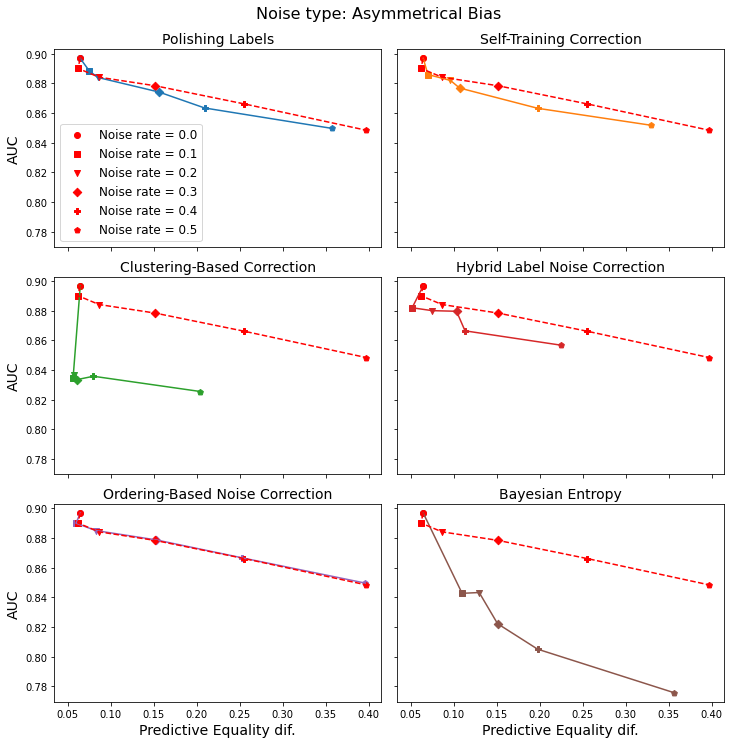

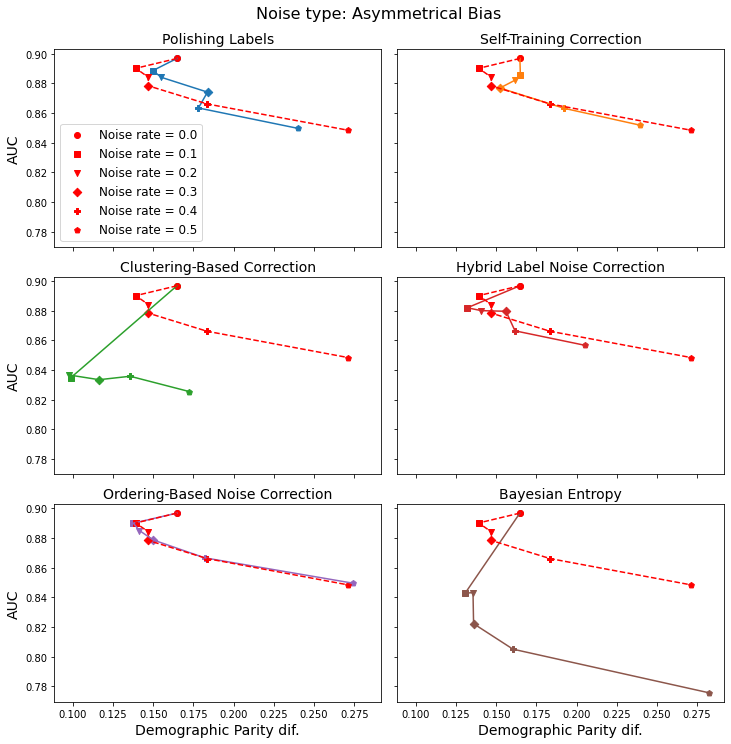

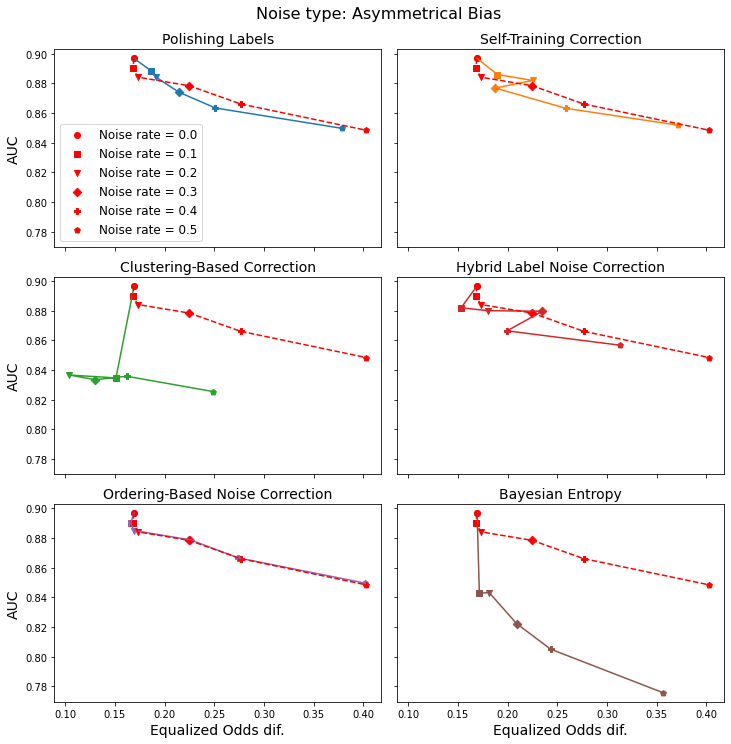

In [93]:
for fair_metric in fair_metrics:
    trade_off_separate_algs('bias', 'original', fair_metric, nr)

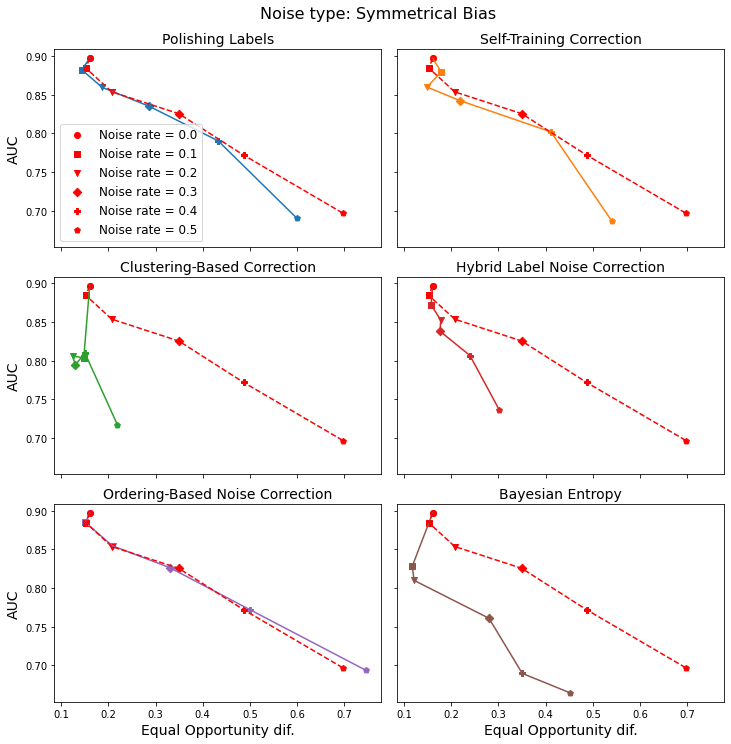

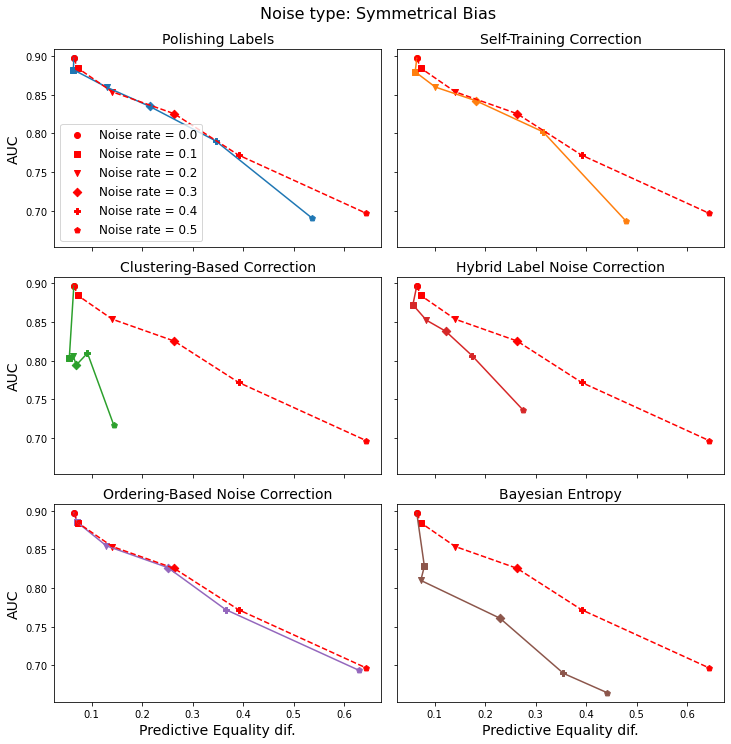

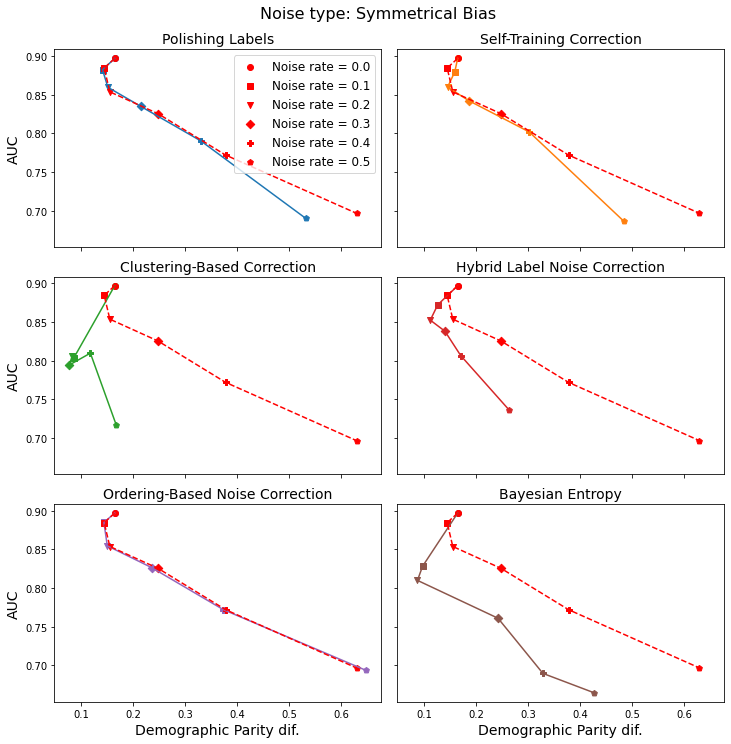

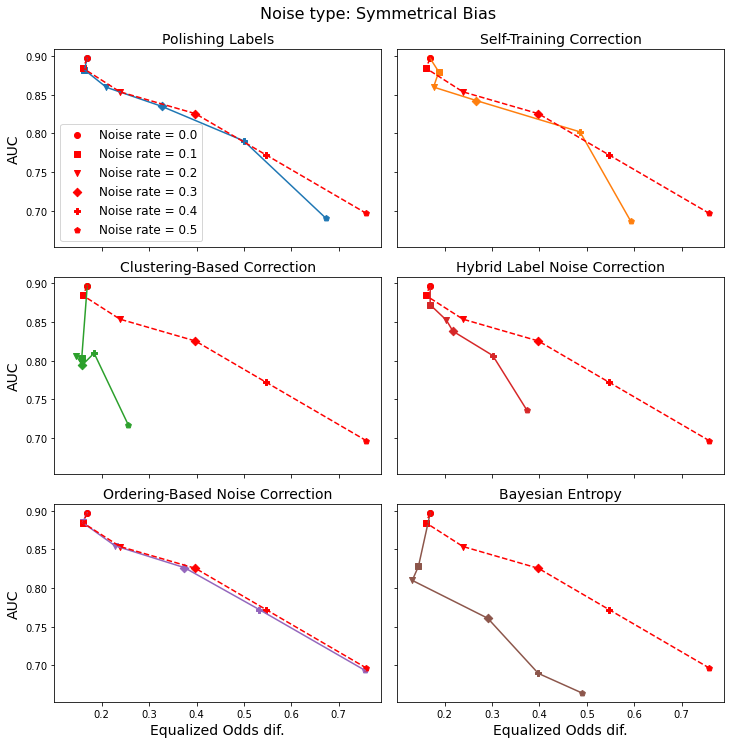

In [94]:
for fair_metric in fair_metrics:
    trade_off_separate_algs('balanced_bias', 'original', fair_metric, nr)

In [95]:
def show_trade_off(noise_type, pred_metric, fair_metric, test_set, noise_rate, xlimit=None, ylimit=None):
    if test_set == 'original':
        train_sets = ['original', 'noisy']
    else:
        train_sets = ['noisy']

    for train_set in train_sets:
        predictive_performance = []
        fairness = []
        for dataset in attr.keys():
            run = runs[noise_type][f'{dataset}_{attr[dataset]}_{algorithms[0]}']
            run = run.loc[(run['tags.test_set'] == test_set) & (run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == train_set)]
            predictive_performance.append(run[f'metrics.{pred_metric}'].values[0])
            fairness.append(run[f'metrics.{fair_metric}'].values[0])

        if train_set == 'original':
            c = 'black'
        else:
            c = 'r'
        
        plt.scatter(np.mean(fairness), np.mean(predictive_performance), label=train_set, color=c, marker='x', s=100)
        plt.axvline(x=np.mean(fairness), alpha=0.2, color=c, linestyle='--')
        plt.axhline(y=np.mean(predictive_performance), alpha=0.2, color=c, linestyle='--')
        

    for alg in algorithms:
        predictive_performance = []
        fairness = []
        for dataset in attr.keys():
            run = runs['bias'][f'{dataset}_{attr[dataset]}_{alg}']
            run = run.loc[(run['tags.test_set'] == test_set) & (run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')]
            predictive_performance.append(run[f'metrics.{pred_metric}'].values[0])
            fairness.append(run[f'metrics.{fair_metric}'].values[0])
        plt.scatter(np.mean(fairness), np.mean(predictive_performance), label=alg, s=40, c=colors[alg])

    plt.title(f'Noise rate: {noise_rate}', fontsize=14)
    plt.xlabel(metric_names[fair_metric], fontsize=14)
    plt.ylabel(metric_names[pred_metric], fontsize=14)
    if xlimit:
        plt.xlim(xlimit)
    if ylimit:
        plt.ylim(ylimit)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
    plt.savefig(f'presentation/{int(noise_rate*10)}.png', bbox_inches='tight')
    plt.show()

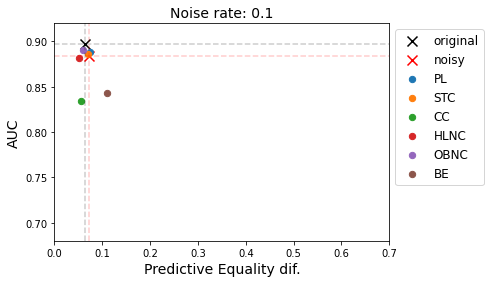

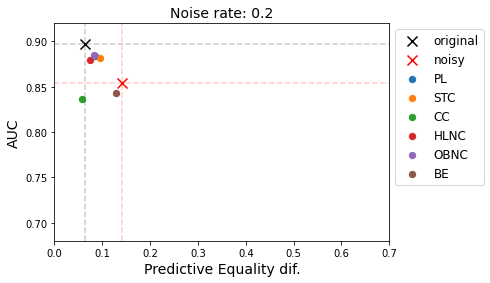

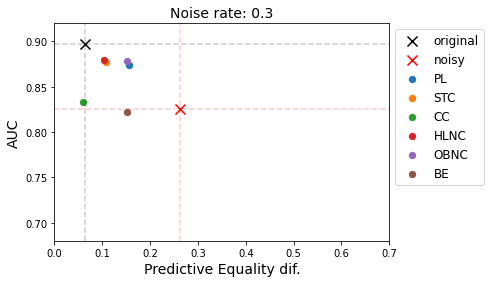

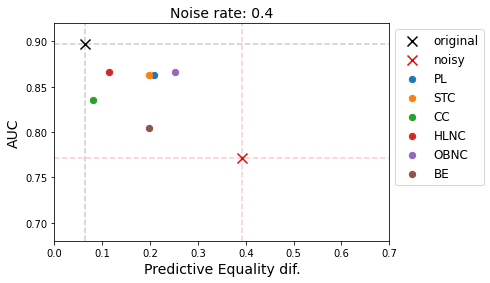

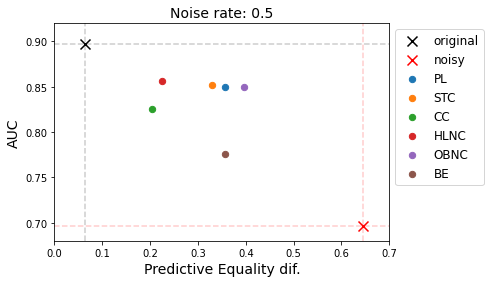

In [96]:
for noise_rate in nr:
    show_trade_off('balanced_bias', 'roc_auc', 'predictive_equality_difference_0.5', 'original', noise_rate, xlimit=(0, 0.7), ylimit=(0.68, 0.92))

In [97]:
import imageio

images = []
for i in range(1, len(nr)+1):
    images.append(imageio.imread(f'presentation/{i}.png'))
imageio.mimsave(f'presentation/balanced_bias_original.gif', images, format='GIF', duration=0.5)

## Corrected test set

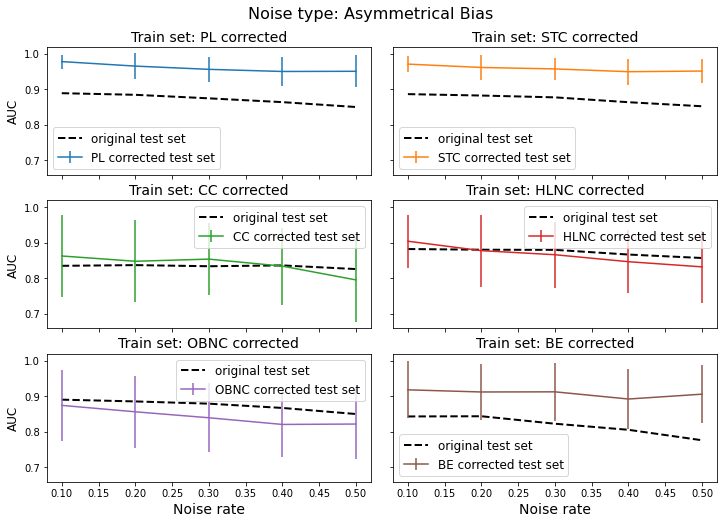

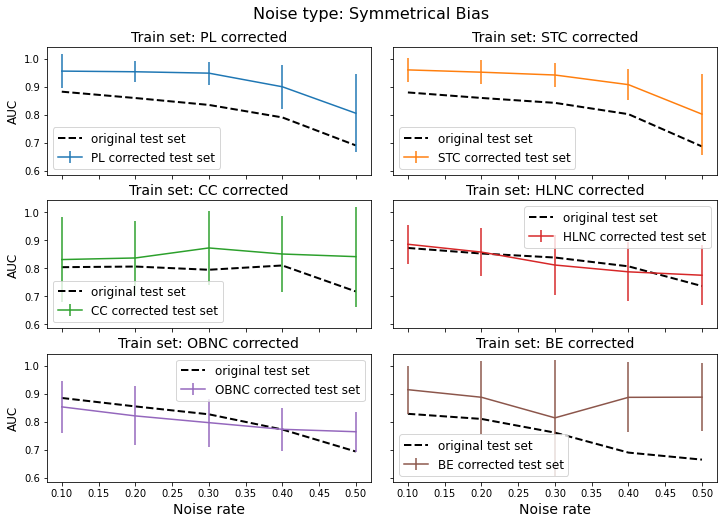

In [98]:
for noise_type in noise_types[2:]:
    show_corrected_test_performance(noise_type, 'roc_auc')

KeyboardInterrupt: 

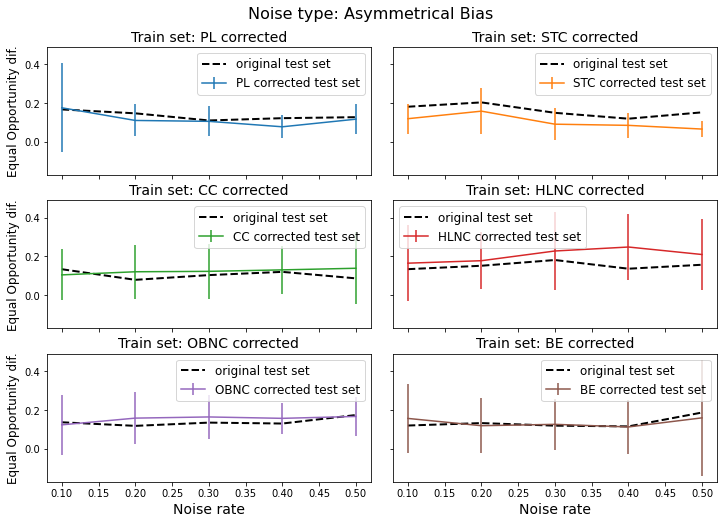

In [99]:
for fair_metric in fair_metrics:
    for noise_type in noise_types[2:]:
        show_corrected_test_performance(noise_type, fair_metric)

# Fairness benchmark experiments

## Dataset characterization

In [ ]:
dataset_stats = pd.DataFrame(columns=['dataset', 'instances', 'features', 'positive (%)'])

i = 0
for dataset in attr_fairness.keys():
    data = pd.read_csv(f'../data/{dataset}.csv')
    dataset_stats.loc[i] = [
        dataset,
        data.shape[0],
        data.shape[1] - 1,
        "{:.0f} %".format((data[data['y'] == 1].shape[0]/data.shape[0])*100)
    ]
    i += 1

dataset_stats.to_csv('thesis_report/fairness_dataset_stats1.csv', index=False)
dataset_stats

,dataset,instances,features,positive (%)
0,adult,45175,104,25 %
1,german,1000,58,70 %
2,compas,4966,11,50 %
3,ricci,118,7,47 %
4,diabetes,34071,48,33 %
5,titanic,1309,11,38 %


In [ ]:
dataset_stats = pd.DataFrame(columns=['dataset', 'sensitive attribute', 'protected (%)', 'positive in protected group (%)', 'positive in unprotected group (%)'])

i = 0
for dataset in attr_fairness.keys():
    data = pd.read_csv(f'../data/{dataset}.csv')
    for attr_name in attr_fairness[dataset]:
        dataset_stats.loc[i] = [
            dataset,
            attr_name,
            "{:.0f} %".format((data[data[attr_name] == 1].shape[0]/data.shape[0])*100),
            "{:.0f} %".format((data[(data[attr_name] == 1) & (data['y'] == 1)].shape[0]/data[data[attr_name] == 1].shape[0])*100),
            "{:.0f} %".format((data[(data[attr_name] == 0) & (data['y'] == 1)].shape[0]/data[data[attr_name] == 0].shape[0])*100),
        ]
        i += 1

dataset_stats.to_csv('thesis_report/fairness_dataset_stats2.csv', index=False)
dataset_stats

,dataset,sensitive attribute,protected (%),positive in protected group (%),positive in unprotected group (%)
0,adult,sex_Male,68 %,31 %,11 %
1,adult,race_White,86 %,26 %,16 %
2,german,sex_Male,69 %,72 %,65 %
3,compas,sex,81 %,53 %,39 %
4,compas,race_Caucasian,40 %,42 %,55 %
5,ricci,Race_W,58 %,60 %,30 %
6,diabetes,race_Caucasian,75 %,34 %,32 %
7,titanic,sex,64 %,19 %,73 %


## Originally biased test set

In [ ]:
def trade_off(test_set, fair_metric, pred_metric):
    for alg in algorithms:
        fairness = []
        predictive = []
        for dataset in attr_fairness.keys():
            for sensitive_attr in attr_fairness[dataset]:
                run = runs['fairness'][f'{dataset}_{sensitive_attr}_{alg}']
                run = run.loc[(run['tags.train_set'] == 'corrected') & (run['tags.test_set'] == test_set)]
                if pd.notna(run[f'metrics.{fair_metric}'].values[0]):
                    fairness.append(run[f'metrics.{fair_metric}'].values[0])
                if pd.notna(run[f'metrics.{pred_metric}'].values[0]):
                    predictive.append(run[f'metrics.{pred_metric}'].values[0])
        plt.scatter(np.mean(fairness), np.mean(predictive), label=alg, color=colors[alg])

    fairness = []
    predictive = []
    for dataset in attr_fairness.keys():
        for sensitive_attr in attr_fairness[dataset]:
            run = runs['fairness'][f'{dataset}_{sensitive_attr}_{algorithms[0]}']
            run = run.loc[(run['tags.train_set'] == 'noisy') & (run['tags.test_set'] == test_set)]
            if pd.notna(run[f'metrics.{fair_metric}'].values[0]):
                fairness.append(run[f'metrics.{fair_metric}'].values[0])
            if pd.notna(run[f'metrics.{pred_metric}'].values[0]):
                predictive.append(run[f'metrics.{pred_metric}'].values[0])
    plt.scatter(np.mean(fairness), np.mean(predictive), label='originally biased', color='red', marker='x')

    lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
    plt.xlabel(metric_names[fair_metric], fontsize=14)
    plt.ylabel(metric_names[pred_metric], fontsize=14)
    plt.title(f'Originally biased test set' if test_set == 'noisy' else f'Corrected test set', fontsize=14)
    plt.savefig(f'thesis_report/fairness_benchmarks/{test_set}_test_{fair_metric}_{pred_metric}.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

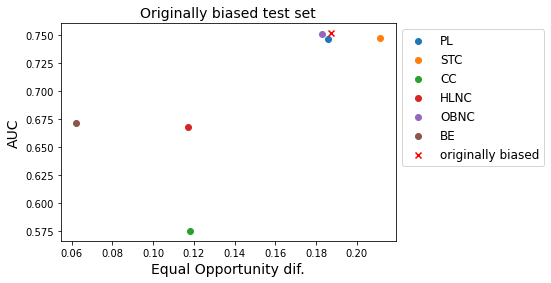

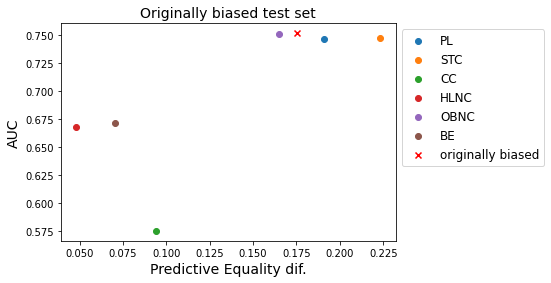

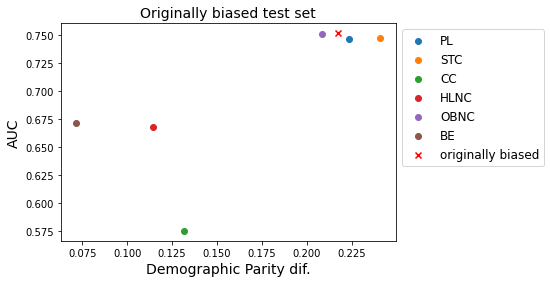

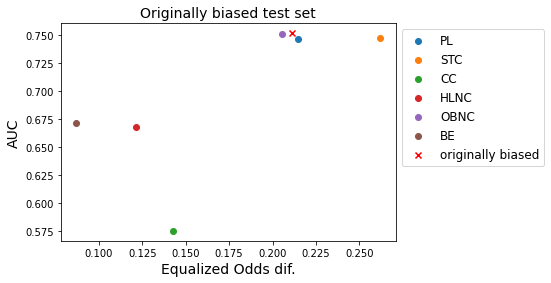

In [ ]:
for fair_metric in fair_metrics:
    trade_off('noisy', fair_metric, 'roc_auc')

# Corrected test set

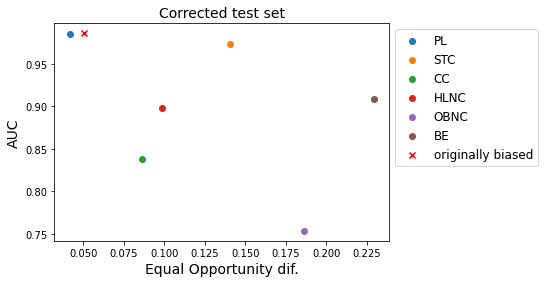

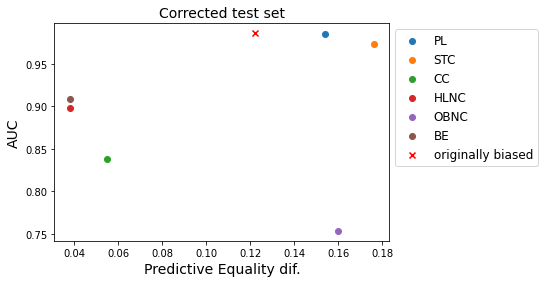

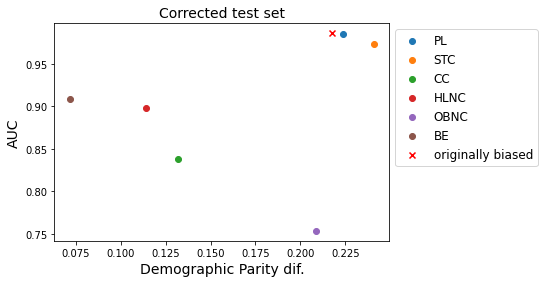

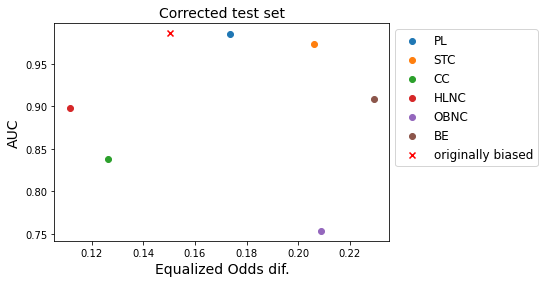

In [ ]:
for fair_metric in fair_metrics:
    trade_off('corrected', fair_metric, 'roc_auc')